Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [68]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [69]:
df = pd.read_csv('/datasets/car_data.csv')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [71]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [72]:
df.isna().any(axis=1).sum()/len(df)

0.30633322892239445

I will drop all missing values.

In [73]:
df.dropna(inplace=True)

In [74]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [75]:
df.duplicated().sum()

247

In [76]:
df.drop_duplicates(inplace=True)

In [77]:
#Using only top 50 models as it would take so long to encode all.
top_50  = [name for name in df['Model'].value_counts().head(50).index]

In [78]:
df.loc[~df['Model'].isin(top_50), 'Model'] = 'other'

In [79]:
df['Model'].value_counts()

other          70600
golf           20184
3er            14877
polo            8797
corsa           8255
astra           7626
a4              7525
passat          7415
c_klasse        6478
5er             6221
e_klasse        5212
a3              4481
focus           4387
a6              4337
fiesta          3992
2_reihe         3825
transporter     3467
twingo          3092
1er             3050
a_klasse        3002
fortwo          2881
vectra          2794
3_reihe         2638
mondeo          2572
touran          2543
clio            2382
zafira          2169
punto           2090
megane          2073
ibiza           1978
lupo            1763
octavia         1728
cooper          1723
fabia           1701
ka              1701
clk             1443
x_reihe         1345
micra           1178
caddy           1133
i_reihe         1081
leon            1068
slk             1042
sharan          1021
scenic           996
laguna           996
6_reihe          976
80               967
omega        

In [13]:
#OHE
df_ohe = pd.get_dummies(df,columns=['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired'],  drop_first=True)

In [14]:
df.head(50)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
10,26/03/2016 19:54,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,26/03/2016 00:00,0,96224,06/04/2016 10:45
11,07/04/2016 10:06,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,07/04/2016 00:00,0,57290,07/04/2016 10:25
14,21/03/2016 12:57,17999,suv,2011,manual,190,other,70000,3,gasoline,nissan,no,21/03/2016 00:00,0,4177,06/04/2016 07:45
17,20/03/2016 10:25,1750,small,2004,auto,75,twingo,150000,2,petrol,renault,no,20/03/2016 00:00,0,65599,06/04/2016 13:16
18,23/03/2016 15:48,7550,bus,2007,manual,136,other,150000,6,gasoline,ford,no,23/03/2016 00:00,0,88361,05/04/2016 18:45


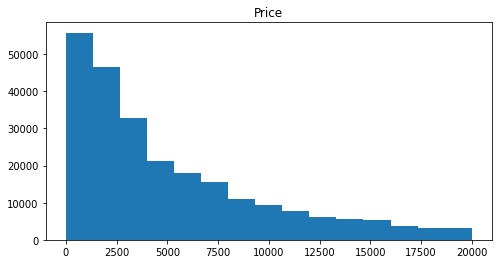

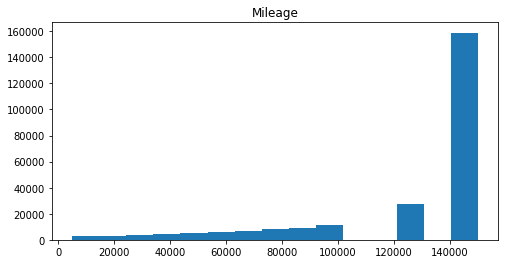

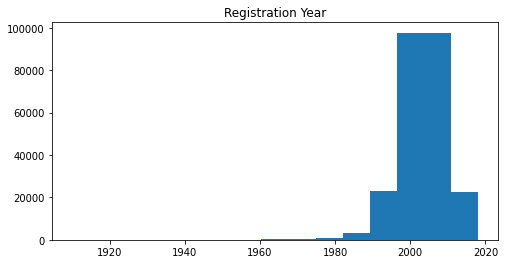

In [15]:
plt.figure(figsize=(8,4))
plt.hist(df['Price'], bins=15)
plt.title('Price')
plt.show()
plt.figure(figsize=(8,4))
plt.hist(df['Mileage'], bins=15)
plt.title('Mileage')
plt.show()
plt.figure(figsize=(8,4))
plt.hist(df['RegistrationYear'], bins=15)
plt.xlim()
plt.title('Registration Year')
plt.show()

Price ranges from $0 to $20k with a skewed right distribution. There are more than 2500 cars with a price of $0 which is strange but the cars could be totaled so, I'll leave them as they are. Majority of the cars have a mileage over 140k which could explain the lower prices. 

## Model training

In [16]:
#Determining features and target
x = df_ohe.drop(['Price','DateCreated', 'DateCrawled', 'NumberOfPictures', 'PostalCode','LastSeen'], axis=1)
y = df_ohe['Price']

In [17]:
#Splitting data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

Hyperparameter Tuning for Decision Tree model along with the time required:

In [18]:
%%time
best_est = []
best_depth = []
best_rmse = 0
for est in (1,10):
    for max_depth in range (1, 10):
        model = RandomForestRegressor(random_state=42,n_estimators=est,max_depth=max_depth)
        score = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
        final_score = score.sum() / len(score)
        rmse = np.sqrt(-final_score)
        if rmse > best_rmse:
            best_est = est
            best_depth = max_depth

print('max_depth =', best_depth, 'best_est =', best_est, 'score =', rmse)

max_depth = 9 best_est = 10 score = 2023.8409861456348
CPU times: user 3min 21s, sys: 3.53 s, total: 3min 25s
Wall time: 3min 25s


Hyperparameter Tuning for Random Forest model along with the time required

In [19]:
%%time
best_depth = []
best_rmse = 0
for max_depth in range (1, 15):
    model = DecisionTreeRegressor(random_state=42,max_depth=max_depth)
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    final_score = score.sum() / len(score)
    rmse = np.sqrt(-final_score)
    if rmse > best_rmse:
        best_depth = max_depth
        
print('max_depth =', max_depth, 'score =',rmse)

max_depth = 14 score = 1968.775891299901
CPU times: user 1min 2s, sys: 2.47 s, total: 1min 4s
Wall time: 1min 4s


Linear Regression model along with the time required

In [20]:
%%time
model = LinearRegression()
score = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
final_score = score.sum() / len(score)
print('RMSE =',np.sqrt(-final_score))

RMSE = 2860.729109068592
CPU times: user 14.3 s, sys: 3.81 s, total: 18.1 s
Wall time: 18.1 s


In [21]:
#Parameters for GridSearchCv
param_grid = {'learning_rate': [1, 0.1, 0.01],
         'max_depth': [5,8,10],
         'num_leaves': [4,6,8]
          }

In [22]:
model = LGBMRegressor(random_state=42,verbose=0)

Finding the best parameters for LightGBM model

In [23]:
grid = GridSearchCV(model, param_grid, cv=5, n_jobs=5, scoring='neg_root_mean_squared_error')

In [24]:
%%time
grid.fit(x_train, y_train)
print('Best Parameters:',grid.best_params_)
print('Best Score:',grid.best_score_)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Best Parameters: {'learning_rate': 1, 'max_depth': 8, 'num_leaves': 8}
Best Score: -1789.0483266168442
CPU times: user 2.73 s, sys: 265 ms, total: 2.99 s
Wall time: 4min 51s


Training the LightGBM model and its speed

In [25]:
model = LGBMRegressor(**grid.best_params_,random_state=42)

In [26]:
%%time
model.fit(x_train,y_train)

CPU times: user 2.12 s, sys: 43.9 ms, total: 2.17 s
Wall time: 2.19 s


LGBMRegressor(learning_rate=1, max_depth=8, num_leaves=8, random_state=42)

Predictions of LightGBM model and time required

In [27]:
%%time
y_pred = model.predict(x_test)
print('RMSE = ', np.sqrt(mean_squared_error(y_pred, y_test)))

RMSE =  1771.2200299254603
CPU times: user 318 ms, sys: 14.3 ms, total: 333 ms
Wall time: 314 ms
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

## Conclusion

Data was preprocessed by dropping the missing values and duplicates. For encoding of categorical features, OHE was used. 4 different models were trained with hyperparameter tuning which are decision tree, random forest, linear regression, and Lightgbm. The RMSE scores for each model are 1872,1865,2741, and 1684, respectively. Best model was found to be Lightgbm. The quality of prediction is 1702 (RMSE), the speed of prediction is 223 ms, and the time required for training is 1.92 s. 